In [2]:
from ase.io import read
from hubbard.data import AtomicData
from hubbard.gutz import GhostGutzwiller
from hubbard.utils.tools import setup_seed
from hubbard.utils.tools import get_semicircle_e_list
import numpy as np
from hubbard.data import _keys
from hubbard.operator.soc import get_soc_matrix_cubic_basis

setup_seed(1238)
U = 3.
J = 0.15 * U # 0.25 * U
Up = U - 2*J
Jp = J
lbd = 0.
n_threads = 50

alpha = 1.
Delta = 0.
e_list = get_semicircle_e_list(nmesh=1000, d=2)
eks = alpha * e_list[:,None,None] * np.eye(3)[None,:,:] + 0j

onsite = np.eye(3) * (-Delta) + 0j
# SOC = get_soc_matrix_cubic_basis("d").reshape(2,5,2,5).transpose(1,0,3,2).reshape(10,10)[[0,1,2,3,6,7]][:,[0,1,2,3,6,7]]
SOC = get_soc_matrix_cubic_basis("p").reshape(2,3,2,3).transpose(1,0,3,2).reshape(6,6)
onsite = np.kron(onsite, np.eye(2)) + lbd * SOC
onsite = onsite[None,:,:]
phy_onsite = {
    "C": onsite
}

intparams = {"C":[{"U":U,"Up":Up,"J":J, "Jp":Jp}]}

gga = GhostGutzwiller(
    atomic_number=np.array([6]),
    nocc=4,
    basis={"C":[3]},
    idx_intorb={"C":[0]},
    naux=3,
    intparams=intparams,
    nspin=4,
    kBT=0.002,
    mutol=1e-4,
    natural_orbital=False,
    decouple_bath=True,
    solver="DMRG",
    mixer_options={"method": "Linear", "a": 0.5},  # {"method": "Linear", "a":0.5},
    iscomplex=True,
    solver_options={"reorder": False, "iprint": 0, "n_threads": n_threads, "nupdate": 8, "eig_cutoff": 1e-7, "bond_dim": 1000, "su2": False}#{"mfepmin":2000, "channels": 10, "Ptol": 1e-5},
)

atomicdata = AtomicData.from_ase(
    read("../../hubbard/test/C_cube.vasp"),
    r_max=3.1
    )

atomicdata = AtomicData.to_AtomicDataDict(atomicdata)
atomicdata[_keys.HAMILTONIAN_KEY] = eks
atomicdata[_keys.PHY_ONSITE_KEY] = phy_onsite

driver threads:   OpenMP = 1 TBB = 0 BLIS = 0 MKL = NONE  SeqType = Tasked MKLIntLen = 4
 THREADING = 2 layers : Global | Operator BatchedGEMM 
 NUMBER : Global = 50 Operator = 50 Quanta = 0 MKL = 1
 COMPLEX = 1 SINGLE-PREC = 0 KSYMM = 0


In [4]:
gga.run(atomicdata, 100, tol=1e-3)

DM_kin:  [4.28516788e-04 5.65309595e-04 9.29241965e-04 1.28060658e-03
 3.94014239e-03 4.68979220e-01 4.90965170e-01 4.96920585e-01
 5.01052574e-01 5.03862495e-01 5.41392678e-01 9.96511397e-01
 9.96655706e-01 9.98526183e-01 9.98709361e-01 9.99283983e-01
 9.99943025e-01 9.99994073e-01]
<class 'block2.cpx.sgf.IdentityAddedMPO'> <class 'hubbard.solver.dmrg_solver.DMRG_solver'>
 -- Current error: 2.74353
DM_kin:  [7.62900763e-04 7.90939031e-04 1.68403958e-03 1.72793214e-03
 4.14352895e-03 4.40590829e-01 4.78985914e-01 4.91656741e-01
 4.92230243e-01 5.01311260e-01 5.91922751e-01 9.97981297e-01
 9.98029040e-01 9.99344821e-01 9.99447409e-01 9.99608935e-01
 9.99779021e-01 9.99993230e-01]
<class 'block2.cpx.sgf.IdentityAddedMPO'> <class 'hubbard.solver.dmrg_solver.DMRG_solver'>
 -- Current error: 1.78066
DM_kin:  [0.0010784  0.00137278 0.0016686  0.00210666 0.00339455 0.44764625
 0.49576343 0.49994436 0.50741255 0.51515051 0.57441863 0.95297208
 0.99899945 0.99912086 0.99962793 0.99969307 0.9997

KeyboardInterrupt: 

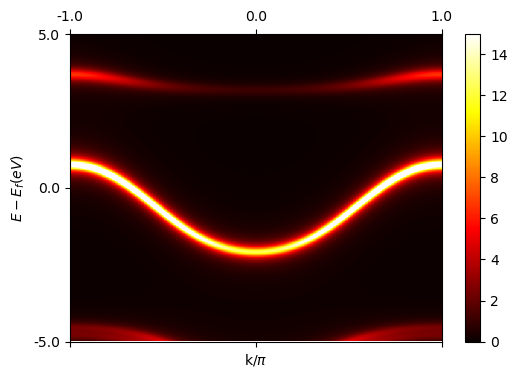

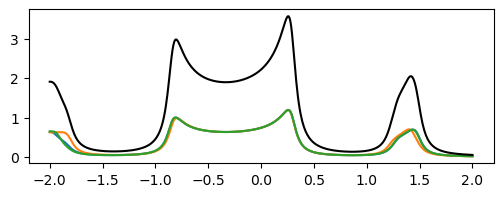

In [5]:
eks = alpha * (-np.cos(np.linspace(-1,1, 500)*np.pi))[:,None,None] * np.eye(3)[None,:,:] + 0j
atomicdata = gga.idp_phy(atomicdata)
atomicdata[_keys.HAMILTONIAN_KEY] = eks

Es = np.linspace(-2,2, 500) + gga.E_fermi
GF = gga.compute_GF(Es=Es, data=atomicdata, eta=0.06)
ARPES = -(1/np.pi)*GF.imag.diagonal(offset=0, axis1=-1, axis2=-2)
pdos = ARPES.sum(0) / ARPES.shape[0]
pdos = pdos.reshape(-1,3,2).sum(-1)
dos = pdos.sum(-1)
ARPES = ARPES.sum(-1)
ntick = 3

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6,4))
m = ax.matshow(ARPES[:,::-1].T, cmap="hot", vmin=0, vmax=15)
ax.set_aspect('auto')  # override the default 'equal'
ax.set_xlabel(r"k/$\pi$")
ax.set_ylabel(r"$E-E_f (eV)$")
ax.set_yticks(ticks=np.linspace(0,ARPES.shape[1],ntick), labels=np.linspace(-5,5,ntick)[::-1])
ax.set_xticks(ticks=np.linspace(0,ARPES.shape[0],ntick), labels=np.linspace(1,-1,ntick)[::-1])
fig.colorbar(m)
plt.show()

plt.figure(figsize=(6,2))
# plt.plot(Es, dos)
plt.plot(Es-gga.E_fermi, pdos)
# plt.legend(["d", "p"])
plt.plot(Es-gga.E_fermi, dos, c="black", label="dos")
# plt.legend(["d", "p"])
plt.show()